In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [42]:
LABEL_FORMULATIONS = [
    ["concerning", "normal"],
    ["urgent", "non-urgent"],
    ["trigger", "non-trigger"],
    ["distressed", "stable"],
    ["needs support", "doing well"]
]

def get_label_str(labels):
    #Converts label list to string format used in filenames
    return "_".join(labels).replace(" ", "-")

def analyze_prediction_distributions(results_dir, model_name):
    """
    Analyze prediction distributions from saved CSV files
    
    Args:
        results_dir: Directory containing the prediction CSV files
        model_name: 'base' or 'nli' to identify which model's results to analyze
    """
    all_distributions = []
    
    print("\n" + "="*70)
    print(f"ANALYZING PREDICTION DISTRIBUTIONS - {model_name.upper()} MODEL")
    print("="*70)
    
    for labels in LABEL_FORMULATIONS:
        label_str = get_label_str(labels)
        
        for language in ['Arabic', 'English']:
            if model_name == 'base':
                # Base model: ZeroShot_base_{label_str}_{language}_*.csv
                pattern = f"ZeroShot_base_{label_str}_{language}_*.csv"
            else:
                # NLI model: ZeroShot_{label_str}_{language}_*.csv
                pattern = f"ZeroShot_{label_str}_{language}_*.csv"
            
            file_pattern = os.path.join(results_dir, pattern)
            matching_files = glob(file_pattern)
            
            if not matching_files:
                print(f"WARNING: No file found for {label_str} - {language}")
                print(f"  Searched for: {pattern}")
                continue
            
            # Use most recent file
            file_path = sorted(matching_files)[-1]
            print(f"  Found: {os.path.basename(file_path)}")

            df = pd.read_csv(file_path)
            
            #distribution statistics
            total = len(df)
            pred_0_count = (df['prediction'] == 0).sum()
            pred_1_count = (df['prediction'] == 1).sum()
            pred_0_pct = (pred_0_count / total) * 100
            pred_1_pct = (pred_1_count / total) * 100
            
            #True label distribution should be 50/50
            true_0_count = (df['Trigger'] == 0).sum()
            true_1_count = (df['Trigger'] == 1).sum()
            true_0_pct = (true_0_count / total)* 100
            true_1_pct = (true_1_count / total) * 100
            
            print(f"\n{labels} | {language}")
            print("-" * 50)
            print(f"Total samples: {total}")
            print(f"True distribution:")
            print(f"  Class 0: {true_0_count} ({true_0_pct:.1f}%)")
            print(f"  Class 1: {true_1_count} ({true_1_pct:.1f}%)")
            print(f"Predicted distribution:")
            print(f"  Class 0: {pred_0_count} ({pred_0_pct:.1f}%)")
            print(f"  Class 1: {pred_1_count} ({pred_1_pct:.1f}%)")
            
            #prediction bias (positive = biased toward 1, negative = biased toward 0)
            bias = pred_1_pct - true_1_pct
            print(f"Prediction bias: {bias:+.1f}% toward class {'1' if bias > 0 else '0'}")
            
            all_distributions.append({
                'Model': model_name.upper(),
                'Label_Formulation': str(labels),
                'Language': language,
                'Total_Samples': total,
                'True_Class_0_Count': true_0_count,
                'True_Class_0_Pct': true_0_pct,
                'True_Class_1_Count': true_1_count,
                'True_Class_1_Pct': true_1_pct,
                'Pred_Class_0_Count': pred_0_count,
                'Pred_Class_0_Pct': pred_0_pct,
                'Pred_Class_1_Count': pred_1_count,
                'Pred_Class_1_Pct': pred_1_pct,
                'Prediction_Bias': bias
            })
    
    return pd.DataFrame(all_distributions)


In [ ]:
path = os.getcwd()

base_dir = os.path.join(path, "zeroshot_base_xlmr_roberta_results")
nli_dir = os.path.join(path, "zeroshot_baseline_xlm_roberta_nli_results")  # Updated directory name

if not os.path.exists(base_dir):
    print(f"ERROR: Base model results directory not found: {base_dir}")
    base_df = pd.DataFrame()
else:
    base_df = analyze_prediction_distributions(base_dir, "base")

if not os.path.exists(nli_dir):
    print(f"ERROR: NLI model results directory not found: {nli_dir}")
    nli_df = pd.DataFrame()
else:
    nli_df = analyze_prediction_distributions(nli_dir, "nli")

if not base_df.empty and not nli_df.empty:
    combined_df = pd.concat([base_df, nli_df], ignore_index=True)
elif not base_df.empty:
    combined_df = base_df
elif not nli_df.empty:
    combined_df = nli_df
else:
    print("ERROR: No data to analyze")
    exit()

analysis_dir = os.path.join(path, "baseline_labels_analysis")
os.makedirs(analysis_dir, exist_ok=True)
full_csv_path = os.path.join(analysis_dir, "prediction_distributions_full.csv")
combined_df.to_csv(full_csv_path, index=False)

# Create summary table with counts and percentages for display
summary_display_df = combined_df[[
    'Model', 'Label_Formulation', 'Language', 
    'Pred_Class_0_Count', 'Pred_Class_0_Pct',
    'Pred_Class_1_Count', 'Pred_Class_1_Pct',
    'Prediction_Bias']].copy()

summary_display_df['Pred_0'] = summary_display_df.apply(lambda row: f"{int(row['Pred_Class_0_Count'])} ({row['Pred_Class_0_Pct']:.1f}%)", axis=1)
summary_display_df['Pred_1'] = summary_display_df.apply(lambda row: f"{int(row['Pred_Class_1_Count'])} ({row['Pred_Class_1_Pct']:.1f}%)", axis=1)

display_df = summary_display_df[['Model', 'Label_Formulation', 'Language', 'Pred_0', 'Pred_1', 'Prediction_Bias']].copy()

print("\n" + "="*70)
print("PREDICTION DISTRIBUTION SUMMARY (Count & Percentage)")
print("="*70)
print(display_df.to_string(index=False))

for model_name in combined_df['Model'].unique():
    model_df = combined_df[combined_df['Model'] == model_name]
    
    pivot_bias = model_df.pivot(
        index='Label_Formulation',
        columns='Language',
        values='Prediction_Bias'
    ).round(1)
    
    model_df_formatted = model_df.copy()
    model_df_formatted['Pred_0_Display'] = model_df_formatted.apply(lambda row: f"{int(row['Pred_Class_0_Count'])} ({row['Pred_Class_0_Pct']:.1f}\\%)", axis=1)
    model_df_formatted['Pred_1_Display'] = model_df_formatted.apply(lambda row: f"{int(row['Pred_Class_1_Count'])} ({row['Pred_Class_1_Pct']:.1f}\\%)", axis=1)
    
    pivot_pred_0 = model_df_formatted.pivot(index='Label_Formulation', columns='Language',values='Pred_0_Display')
    pivot_pred_1 = model_df_formatted.pivot(index='Label_Formulation', columns='Language', values='Pred_1_Display')
    
    pivot_display = pd.DataFrame()
    for lang in ['Arabic', 'English']:
        if lang in pivot_pred_0.columns:
            pivot_display[f'Pred_0_{lang}'] = pivot_pred_0[lang]
            pivot_display[f'Pred_1_{lang}'] = pivot_pred_1[lang]
            pivot_display[f'Bias_{lang}'] = pivot_bias[lang]
    
    latex_str = pivot_display.to_latex(
        escape=False,  
        caption=f"Prediction Distribution Analysis - {model_name} Model (Counts and Percentages)",
        label=f"tab:pred_dist_{model_name.lower()}")
    
    latex_path = os.path.join(analysis_dir, f"prediction_distribution_{model_name.lower()}.tex")
    with open(latex_path, 'w') as f:
        f.write(latex_str)
    
    print(f"\nLaTeX table for {model_name} model saved to: {latex_path}")
    print("\n" + "="*70)
    print(f"LATEX TABLE - {model_name} MODEL")
    print("="*70)
    print(latex_str)

# Create simplified CSV outputs for easy reference
# 1. Counts only
counts_df = combined_df[['Model', 'Label_Formulation', 'Language','Total_Samples', 'Pred_Class_0_Count', 'Pred_Class_1_Count']].copy()
counts_csv_path = os.path.join(analysis_dir, "prediction_distributions_counts.csv")
counts_df.to_csv(counts_csv_path, index=False)

# 2. Percentages only
percentages_df = combined_df[['Model', 'Label_Formulation', 'Language','Pred_Class_0_Pct', 'Pred_Class_1_Pct', 'Prediction_Bias']].copy()
percentages_csv_path = os.path.join(analysis_dir, "prediction_distributions_percentages.csv")
percentages_df.to_csv(percentages_csv_path, index=False)

print(f"\nCounts-only table saved to: {counts_csv_path}")
print(f"Percentages-only table saved to: {percentages_csv_path}")

#combined comparison table with both counts and percentages
#multi-index pivot for both models (showing counts and percentages)
pivot_counts = combined_df.pivot_table(index=['Label_Formulation', 'Model'], columns='Language', values=['Pred_Class_0_Count', 'Pred_Class_1_Count'])
pivot_percentages = combined_df.pivot_table(index=['Label_Formulation', 'Model'], columns='Language', values=['Pred_Class_0_Pct', 'Pred_Class_1_Pct', 'Prediction_Bias']).round(1)
pivot_combined = pd.concat([pivot_counts, pivot_percentages], axis=1)

latex_combined = pivot_combined.to_latex(float_format="%.1f", caption="Prediction Distribution Comparison - Base vs NLI Models (Counts and Percentages)", label="tab:pred_dist_comparison")

latex_combined_path = os.path.join(analysis_dir, "prediction_distribution_combined.tex")
with open(latex_combined_path, 'w') as f:
    f.write(latex_combined)

print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)

for model_name in combined_df['Model'].unique():
    model_data = combined_df[combined_df['Model'] == model_name]
    
    print(f"\n{model_name} Model:")
    print("-" * 50)
    
    for language in ['Arabic', 'English']:
        lang_data = model_data[model_data['Language'] == language]
        avg_bias = lang_data['Prediction_Bias'].mean()
        max_bias_abs = lang_data['Prediction_Bias'].abs().max()
        
        #most biased formulation
        most_biased_idx = lang_data['Prediction_Bias'].abs().idxmax()
        most_biased_row = lang_data.loc[most_biased_idx]
        
        #overall tendency
        majority_bias_1 = (lang_data['Prediction_Bias'] > 10).sum()
        majority_bias_0 = (lang_data['Prediction_Bias'] < -10).sum()
        
        print(f"\n{language}:")
        print(f"  Average prediction bias: {avg_bias:+.1f}%")
        print(f"  Maximum absolute bias: {max_bias_abs:.1f}%")
        print(f"  Formulations biased toward class 1 (>10%): {majority_bias_1}/{len(lang_data)}")
        print(f"  Formulations biased toward class 0 (<-10%): {majority_bias_0}/{len(lang_data)}")
        print(f"  Most biased formulation: {most_biased_row['Label_Formulation']}")
        print(f"    → Predicted: {int(most_biased_row['Pred_Class_1_Count'])}/{int(most_biased_row['Total_Samples'])} as class 1 ({most_biased_row['Pred_Class_1_Pct']:.1f}%)")
        print(f"    → Bias: {most_biased_row['Prediction_Bias']:+.1f}%")

print("\n" + "="*70)
print("PREDICTION DISTRIBUTION ANALYSIS COMPLETE!")
print("="*70)
print(f"All results saved to: {analysis_dir}")
print("\nGenerated files:")
print(f"  - {os.path.basename(full_csv_path)}")
print(f"  - {os.path.basename(counts_csv_path)}")
print(f"  - {os.path.basename(percentages_csv_path)}")
print(f"  - {os.path.basename(latex_combined_path)}")
for model in combined_df['Model'].unique():
    print(f"  - prediction_distribution_{model.lower()}.tex")

In [ ]:
path = os.getcwd() 
arabic_results_path = os.path.join(path, "zeroshot_base_xlmr_roberta_results\\ZeroShot_base_trigger_non-trigger_Arabic_20251125_042246.csv")
english_results_path=  os.path.join(path,"zeroshot_base_xlmr_roberta_results\\ZeroShot_base_trigger_non-trigger_English_20251125_042345.csv" )

arabic_results = pd.read_csv(arabic_results_path)
english_results = pd.read_csv(english_results_path)

print("PREDICTION DISTRIBUTIONS")
print("="*70)
print("\nArabic predictions:")
print(arabic_results['prediction'].value_counts())
print(f"Percentage predicting 1: {(arabic_results['prediction'] == 1).mean():.2%}")

print("\nEnglish predictions:")
print(english_results['prediction'].value_counts())
print(f"Percentage predicting 1: {(english_results['prediction'] == 1).mean():.2%}")

print("\nTrue labels:")
print(arabic_results['Trigger'].value_counts())
print(f"Percentage actually 1: {(arabic_results['Trigger'] == 1).mean():.2%}")

PREDICTION DISTRIBUTIONS

Arabic predictions:
prediction
1    1400
0     782
Name: count, dtype: int64
Percentage predicting 1: 64.16%

English predictions:
prediction
0    2161
1      21
Name: count, dtype: int64
Percentage predicting 1: 0.96%

True labels:
Trigger
0    1091
1    1091
Name: count, dtype: int64
Percentage actually 1: 50.00%



True Label 0:
Arabic avg confidence: 0.5002
English avg confidence: 0.5002

True Label 1:
Arabic avg confidence: 0.5002
English avg confidence: 0.5002


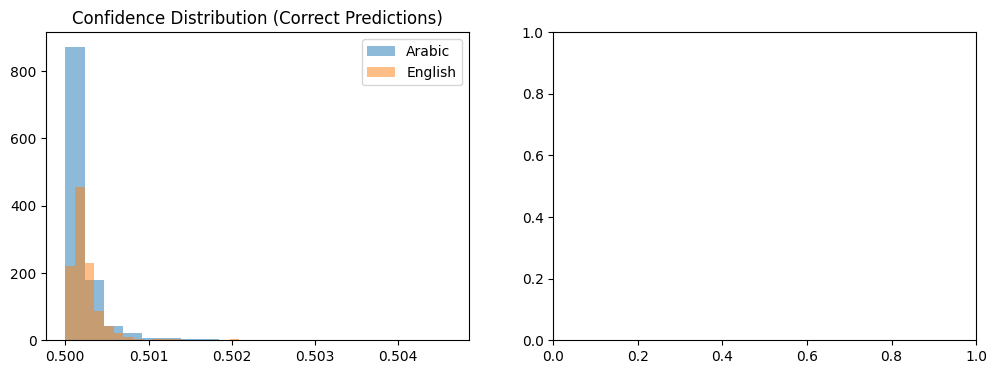

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#confidence for correct predictions
axes[0].hist(arabic_results[arabic_results['correct']]['confidence'], 
             alpha=0.5, label='Arabic', bins=20)
axes[0].hist(english_results[english_results['correct']]['confidence'], 
             alpha=0.5, label='English', bins=20)
axes[0].set_title('Confidence Distribution (Correct Predictions)')
axes[0].legend()

# Compare by true label
for label in [0, 1]:
    print(f"\nTrue Label {label}:")
    print(f"Arabic avg confidence: {arabic_results[arabic_results['Trigger']==label]['confidence'].mean():.4f}")
    print(f"English avg confidence: {english_results[english_results['Trigger']==label]['confidence'].mean():.4f}")

In [ ]:
arabic_errors = arabic_results[~arabic_results['correct']]
english_errors = english_results[~english_results['correct']]

print(f"Arabic false positives: {len(arabic_errors[arabic_errors['Trigger']==0])}")
print(f"Arabic false negatives: {len(arabic_errors[arabic_errors['Trigger']==1])}")
print(f"English false positives: {len(english_errors[english_errors['Trigger']==0])}")
print(f"English false negatives: {len(english_errors[english_errors['Trigger']==1])}")

different_predictions = arabic_results['correct'] != english_results['correct']
print(f"\nStatements classified differently: {different_predictions.sum()}")

Arabic false positives: 676
Arabic false negatives: 367
English false positives: 13
English false negatives: 1083

Statements classified differently: 1393


# Examining examples with greatest confidence differences

In [18]:
# Find cases with biggest confidence differences
combined = arabic_results[['Question', 'Trigger', 'prediction', 'confidence']].copy()
combined.columns = ['Question', 'Trigger', 'pred_ar', 'conf_ar']
combined['Question_eng'] = english_results['Question_eng']
combined['pred_en'] = english_results['prediction']
combined['conf_en'] = english_results['confidence']

combined['conf_diff'] = abs(combined['conf_ar'] - combined['conf_en'])
top_differences = combined.nlargest(10, 'conf_diff')

print(top_differences[['Question', 'Question_eng', 'Trigger', 
                       'pred_ar', 'pred_en', 'conf_ar', 'conf_en']])

                                               Question  \
1964      ملوحه والم خفيف خلف الاسنان بعد تنظيف الجير .   
1090                               كيفية زيادة في الطول   
725           معدل التسترون عندي 678 هذا مرتفع أو منخفض   
403                انا اذهب للتبول كثيرا فما هو السبب ؟   
1735                            المشيمه في اي شهر ترتفع   
584                     هل يؤثر دواء موكسال على الحمل ؟   
1142                  الم في البطن مع خروج دم مع البراز   
1603                            كيف الشفاء من مرض الربو   
1946  كانت نسبة السكر ١٤٤ مع الاكل\r\nفهل هذا المعدل...   
301                  اعاني من الم داخل المهبل ارجو الرد   

                                           Question_eng  Trigger  pred_ar  \
1964  Saltiness and mild pain behind the teeth after...        0        0   
1090                          How to increase in height        1        0   
725   My testosterone level is 678. Is this high or ...        0        0   
403          I go to urinate a lot, what i